In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as FT
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
from classes import ret_classes
from loss import loss
from models import *
from Datasets import *
from utils import *
from operators import Compose
import numpy as np

Model Architecture

(filter size,channels in,no. of filters, stride, padding)

(DarkNet architecture):

(7,3,64,2,3)


M


(3,64,192,1,s)


M


(1,192,128,1,s)


(3,128,256,1,s)


(1,256,256,1,s)


(3,256,512,1,s)


M


[

(1,512,256,1,s)

(3,256,512,1,s)

repeat 4 times]


(1,512,512,1,s)


(3,512,1024,1,s)


M


[

(1,1024,512,1,s)

(3,512,1024,1,s)

repeat 2 times]

------

(The rest of the YOLO architecture):

(3,1024,1024,1,s)


(3,1024,1024,2,1)


(3,1024,1024,1,s)


(3,1024,1024,1,s)

# DARKNET (pre-training on imageNet) 

In [2]:
seed = 100
torch.manual_seed(seed)

lr = 0.1
loss_fn = nn.CrossEntropyLoss(reduction = 'sum')
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
batch = 8
weight_decay = 0   #0.0005
epochs = 2

In [ ]:
DN = darkNet().to(device)
train = ImageNet(classes=ret_classes(),j=3)
val = ImageNet(classes=ret_classes(),train = False)
optimizer = optim.AdamW(DN.parameters(), lr=0.1, weight_decay=0)

In [5]:
train_loader = DataLoader(
        dataset=train,
        batch_size=batch,
        shuffle=True,
)

test_loader = DataLoader(
        dataset=val,
        batch_size=batch,
        shuffle=True,
)

tr_acc_info = []
loss_info = []
val_acc_info = []
val5_acc_info = []
cost_info = []
max_val_acc = 0

In [10]:
checkpoint = torch.load("DN_best.pth")
print("=> Loading checkpoint")
DN.load_state_dict(checkpoint["state_dict"])
optimizer.load_state_dict(checkpoint["optimizer"])
max_val_acc = checkpoint["accuracy"]
#optimizer.param_groups[0]['lr'] = 8.5e-05
#optimizer.param_groups[0]['weight_decay'] = 0
checkpoint["accuracy"], checkpoint["top 5"]

=> Loading checkpoint


(0.347, 0.608)

In [6]:
import json
file = open('performance.json')
print("=> Loading performance")
performance = json.load(file)
tr_acc_info = performance["training accuracy"]
loss_info = performance["loss"]
val_acc_info = performance["validation top-1 accuracy"]
val5_acc_info = performance["validation top-5 accuracy"]
cost_info = performance["cost"]

=> Loading performance


In [ ]:
for epoch in range(2):
    
    loop = tqdm(train_loader)
    total_loss = 0
    tr_crct = 0
    for x,y in loop:
        torch.mps.empty_cache()
        x, y = x.to(device), y.to(device)
        DN = DN.to(device)
        out = DN(x)
        
        loss = loss_fn(out, y)

        _,y_hat = torch.max(out,dim=1)
        tr_crct +=  (y_hat == y).sum().item()
        total_loss += loss.item()

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item()/8)
        
        loss_info.append([])
        loss_info[-1].extend([loss.item()])



    print(f"Cost of epoch was {total_loss/60000}")
    print(f"Accuracy of epoch was {tr_crct/60000}")   
    
    cost_info.append(total_loss/60000)
    tr_acc_info.append(tr_crct/60000)

    optimizer.param_groups[0]['weight_decay'] += 1e-06
    print(optimizer.param_groups[0]['lr'])
    
    DN.eval()
    #only 10% of the test set at a time
    val_crct = 0
    val5_crct = 0
    for i in range(625): #8 at a time 5000 in total per epoch
        
        x_val,y_val = next(iter(test_loader))
        x_val,y_val = x_val.to(device),y_val.to(device)
        DN = DN.to(device)
        with torch.no_grad():
            out_val = DN(x_val)
        _,y_val_hat = torch.max(out_val,dim=1)
        _,y_val5_hat = torch.topk(out_val,5,dim=1)
        
        #top 1 accuracy
        val_crct += (y_val_hat == y_val).sum().item()
        
        #top 5 accuracy
        val5_crct += np.array([y_val[i] in y_val5_hat[i] for i in range(8)]).sum()
    
        
        torch.mps.empty_cache()


    DN.train()
    
    val_acc = (val_crct/5000)
    val5_acc = (val5_crct/5000)
    print(f"Accuracy of epoch on 5000 test samples was (Top 1){val_acc}")
    print(f"Accuracy of epoch on 5000 test samples was (Top 5){val5_acc}")
    val_acc_info.append(val_acc)
    val5_acc_info.append(val5_acc)

    checkpoint = {
                "state_dict": DN.state_dict(),
                "optimizer": optimizer.state_dict(),
                "accuracy": val_acc,
                "top 5": val5_acc
           }
    if val_acc > max_val_acc :
        max_val_acc = val_acc
        print("=> Saving checkpoint (BEST)")
        torch.save(checkpoint, "DN_best2.pth")
    
    print("=> Saving checkpoint (LAST)")
    torch.save(checkpoint, "DN_last2.pth")

In [8]:
performance = {
    "training accuracy" : tr_acc_info,
    "loss" : loss_info,
    "validation top-1 accuracy" : val_acc_info,
    "validation top-5 accuracy" : val5_acc_info,
    "cost" : cost_info
}

In [9]:
save_file = open("performance.json", "w")  
json.dump(performance, save_file, indent = 6)  
save_file.close() 

# YOLO MODEL

In [2]:
seed = 100
torch.manual_seed(seed)

learning_rate = 0.0005  
#device = "mps" if torch.backends.mps.is_available() else "cpu"
device = 'cpu'
batch = 8
weight_decay = 0.0009       #0.0005
epochs = 30
transform = None #Compose([transforms.GaussianBlur((5,5))])

In [3]:
cost_info = []
tr_loss_info = []
val_mAP_info = []
max_val_mAP = 0

In [4]:
model = YOLOv1(pretrained_backbone=True,init_weight=True).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = loss()

train = V1Dataset(dataDir = 'v1', splitDir = 'train')

test = V1Dataset(dataDir = 'v1', splitDir="valid",test=True)


train_loader = DataLoader(
        dataset=train,
        batch_size=batch,
        shuffle=True,
    )


test_loader = DataLoader(
        dataset=test,
        batch_size=batch,
        shuffle=False,
    )

In [9]:
checkpoint = torch.load("YOLO_last.pth")
print("=> Loading checkpoint")
model.load_state_dict(checkpoint["state_dict"])
optimizer.load_state_dict(checkpoint["optimizer"])
max_val_mAP = checkpoint["accuracy"]
optimizer.param_groups[0]['lr'] = 0.0009

=> Loading checkpoint


In [6]:
import json
file = open('performance_YOLO.json')
print("=> Loading performance")
performance = json.load(file)
tr_loss_info = performance["loss"]
cost_info = performance["cost"]
val_mAP_info = performance["mAP"]

=> Loading performance


In [ ]:
for epoch in range(epochs):
    print(epoch)
    train_fn(train_loader, model, optimizer, loss_fn,tr_loss_info,cost_info)   

       
    model.eval()
    pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.1, threshold=0.2,verbose=True,pics=2)
    model.train()

    if optimizer.param_groups[0]['lr'] > 0.00001:
        optimizer.param_groups[0]['lr'] -= 0.000002

    mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5)
    
    print(f"Mean avg prec = {mean_avg_prec}")
    print(f"Mean avg prec2 = {mean_avg_prec2}")
    val_mAP_info.append(mean_avg_prec.item())
    
    checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "accuracy": mean_avg_prec
        }
    if mean_avg_prec > max_val_mAP:
        max_val_mAP = mean_avg_prec 
        print("=> Saving checkpoint (BEST)")
        torch.save(checkpoint, "YOLO_best.pth")
    
    print("=> Saving checkpoint (LAST)")
    torch.save(checkpoint, "YOLO_last.pth")
    

Truth


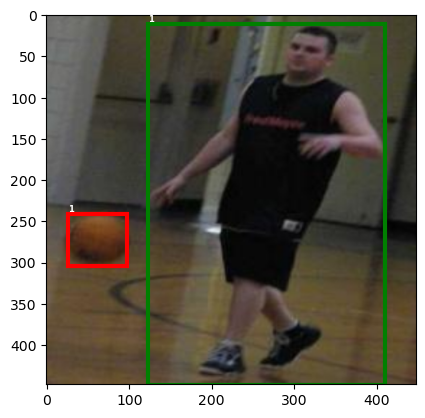

Prediction


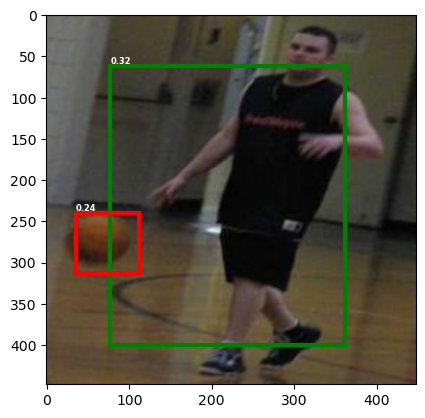

Truth


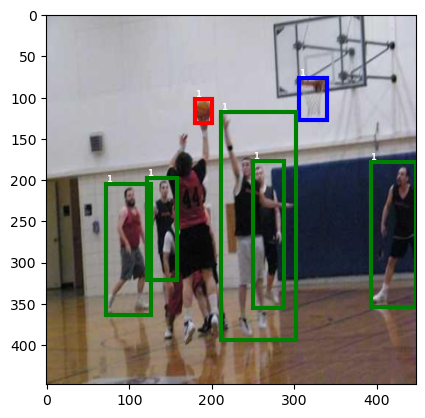

Prediction


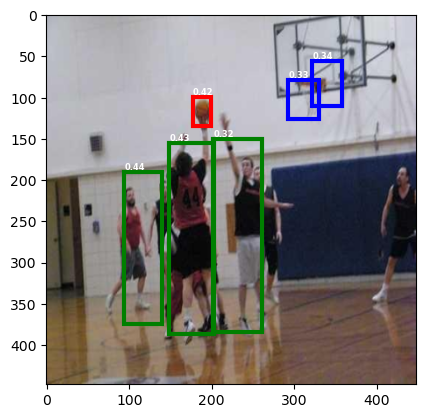

Truth


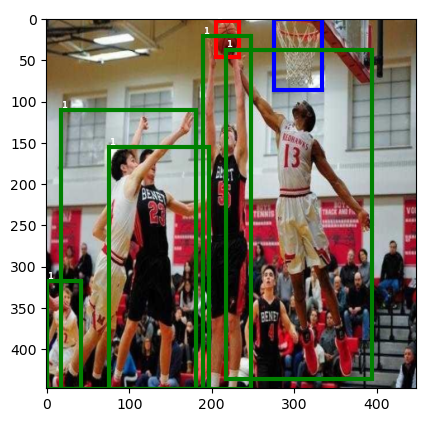

Prediction


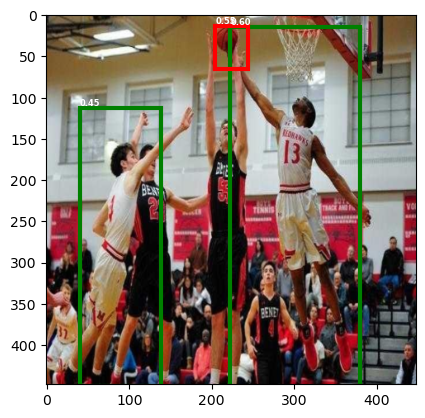

In [11]:
train_test_loader = DataLoader(
        dataset=V1Dataset(test=True),
        batch_size=batch,
        shuffle=True,
    )
model.eval()
pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.15, threshold=0.2,verbose=True,pics=2)
model.train()

mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5)

In [12]:
mean_avg_prec

tensor(0.1255)

In [21]:
model = YOLOv1()
checkpoint = torch.load("YOLO_latest.pth")
print("=> Loading checkpoint")
model.load_state_dict(checkpoint["state_dict"])

=> Loading checkpoint


<All keys matched successfully>

In [ ]:
performance = {
    "loss" : tr_loss_info,
    "cost" : cost_info,
    "mAP" : val_mAP_info
}

In [26]:
save_file = open("performance_YOLO.json", "w")  
json.dump(performance, save_file, indent = 6)  
save_file.close()